In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from sklearn.model_selection import train_test_split

import torch
import torch.nn as tnn
import torch.nn.functional as F
import torch.optim as topti
from torchtext import data
from torchtext.datasets import text_classification
from torchtext.vocab import GloVe

In [2]:
csv = pd.read_csv('OnionOrNot.csv')

#The Onion articles are labeled 1 and the r/NotTheOnion articles are labeled 0.

In [3]:
# Format data to be consitent and get rid of as much punctuation as possible
csv['text'] = csv['text'].str.lower()
csv['text'] = csv['text'].str.replace('’', "'")
#and tiem to ged rid of most common contractions
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": " who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": " you would",
"you'd've": "you would have",
"you'll": " you will",
"you'll've": " you will have",
"you're": "you are",
"you've": "you have"
}
contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, contractions_dict=contractions):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)
csv['text'] = csv.apply(lambda row: expand_contractions(row['text']),axis = 1)

csv['text'] = csv['text'].str.replace(r'&amp;', 'and')
csv['text'] = csv['text'].str.replace(r'-', ' ')
csv['text'] = csv['text'].str.replace(r'[^\s\w]','')
csv['text'] = csv['text'].str.replace(r'\n','')
#make a clean text csv
csv.to_csv('OnionOrNotClean.csv',index = False)

In [4]:
BATCH_SIZE = 32
DIM_SIZE = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda


In [5]:
#just used to break up the preictions into its consituent parts
def measures(outputs, labels)
    tp,tn,fp,fn = 0,0,0,0
    for i in range(len(labels)):
        o = int(outputs[i])
        l = int(labels[i])

        if(o == 0 and l == 0):
            tn +=1
        elif(o == 0 and l == 1):
            fn +=1
        elif(o == 1 and l == 1):
            tp +=1
        elif(o == 1 and l == 0):
            fp += 1
        else:
            print("Label is: {}, Raw it is: {}".format(l,labels[i]))
            print("Output is: {}, Raw it is: {}".format(o,outputs[i]))
    return tp,tn,fp,fn
#basic confusion matrix
def conf_mat(tp,fp,fn,tn):
    print("Predicted   0   1")
    print("Actual")
    print("0           {}  {}".format(tp,fp))
    print("1           {}  {}".format(fn,tn))

In [6]:
#just evaluate on test set
def eval(conf = False):
    num_correct = 0
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    # Save mode
    #torch.save(net.state_dict(), "./model.pth")
    #print("Saved model")

    # Evaluate network on the test dataset.  We aren't calculating gradients, so disable autograd to speed up
    # computations and reduce memory usage.
    with torch.no_grad():
        for batch in testLoader:
            # Get a batch and potentially send it to GPU memory.
            inputs, length, labels = text_field.vocab.vectors[batch.text[0]].to(device), batch.text[1].to(
                device), batch.label.type(torch.FloatTensor).to(device)

            labels -= 1
            
            outputs = net(inputs, length)
            predicted = torch.round(torch.sigmoid(outputs))
            tp_batch, tn_batch, fp_batch, fn_batch = measures(predicted, labels)
            true_pos += tp_batch
            true_neg += tn_batch
            false_pos += fp_batch
            false_neg += fn_batch

            num_correct += (tp_batch + tn_batch)
    accuracy = num_correct / len(dev)
    print(f"Classification accuracy: {accuracy * 100 :.3f} %")
    if conf:
        conf_mat(true_pos,false_pos, false_neg,true_neg)
    return accuracy

Epoch: 1/11..  Loss: 0.5442
Classification accuracy: 82.292 %
Epoch: 2/11..  Loss: 0.4099
Classification accuracy: 84.708 %
Epoch: 3/11..  Loss: 0.3247
Classification accuracy: 86.458 %
Epoch: 4/11..  Loss: 0.2479
Classification accuracy: 87.375 %
Epoch: 5/11..  Loss: 0.1657
Classification accuracy: 87.167 %
Epoch: 6/11..  Loss: 0.1064
Classification accuracy: 87.458 %
Epoch: 7/11..  Loss: 0.0808
Classification accuracy: 86.667 %
Epoch: 8/11..  Loss: 0.0534
Classification accuracy: 85.000 %
Epoch: 9/11..  Loss: 0.0512
Classification accuracy: 86.667 %
Epoch: 10/11..  Loss: 0.0408
Classification accuracy: 85.917 %
Epoch: 11/11..  Loss: 0.0459
Classification accuracy: 86.833 %


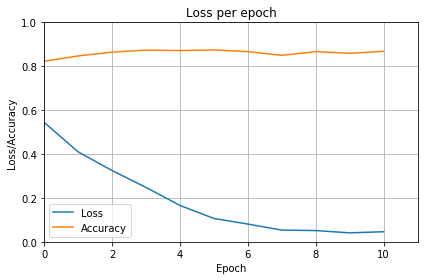

In [7]:
# Class for creating the neural network.
class Network(tnn.Module):
    def __init__(self):
        super(Network, self).__init__()
        #this is an architucture I came up with, it probably is not effiecent
        self.lstm = tnn.LSTM(input_size = DIM_SIZE,hidden_size = 1000, batch_first  = True,
                             num_layers = 2, bidirectional=True)
        self.fc1 = tnn.Linear(1000, 1000)
        self.fc2 = tnn.Linear(1000, 1000)
        self.fc256_1 = tnn.Linear(1000, 1000)
        self.fc256_2 = tnn.Linear(1000, 256)
        self.fc3 = tnn.Linear(256, 128)
        self.fc4 = tnn.Linear(128, 64)
        self.fc5 = tnn.Linear(64, 32)
        self.fc6 = tnn.Linear(32, 1)
        self.drop_layer1 = tnn.Dropout(0.5)
        self.drop_layer2 = tnn.Dropout(0.5)
        self.drop_layer3 = tnn.Dropout(0.5)
        self.drop_layer4 = tnn.Dropout(0.5)
        self.drop_layer5 = tnn.Dropout(0.2)
        self.drop_layer6 = tnn.Dropout(0.2)
        self.drop_layer7 = tnn.Dropout(0.2)
        
    def forward(self, input, length):
        """
        DO NOT MODIFY FUNCTION SIGNATURE
        TODO:
        Create the forward pass through the network.
        """
        x = tnn.utils.rnn.pack_padded_sequence(input,length,batch_first = True)
        #print('Padded Sequence')
        #print(x)
        _,x = self.lstm(x)
       
        x = x[0][3]
        #print('LSTM')
        #print(x)
        x = torch.squeeze(x)
        x = F.leaky_relu(self.fc1(x),negative_slope=0.25)
        x = self.drop_layer1(x)
        x = F.leaky_relu(self.fc2(x),negative_slope=0.25)
        x = self.drop_layer2(x)
        x = F.leaky_relu(self.fc256_1(x),negative_slope=0.25)
        x = self.drop_layer3(x)
        x = F.leaky_relu(self.fc256_2(x),negative_slope=0.25)
        x = self.drop_layer4(x)
        x = F.leaky_relu(self.fc3(x),negative_slope=0.25)
        x = self.drop_layer5(x)
        x = F.leaky_relu(self.fc4(x),negative_slope=0.25)
        x = self.drop_layer6(x)
        x = F.leaky_relu(self.fc5(x),negative_slope=0.25)
        x = self.drop_layer7(x)
        x = self.fc6(x)
        x = x.reshape(-1)
        return x
    
net = Network().to(device)
criterion =tnn.BCEWithLogitsLoss()
optimiser = topti.Adam(net.parameters(), lr=0.001)  # Minimise the loss using the Adam algorithm.

text_field = data.Field(include_lengths=True, batch_first=True)
label_field = data.Field(sequential=False)

new_csv = data.TabularDataset(path='OnionOrNotClean.csv', format='csv',skip_header=True,
    fields=[('text', text_field),('label', label_field)])

train, dev = new_csv.split(0.9)
#we're loading in the GLove 6B pred-traine dmebddings
text_field.build_vocab(train, dev, vectors=GloVe(name="6B", dim=DIM_SIZE))
label_field.build_vocab(train, dev)

trainLoader, testLoader = data.BucketIterator.splits((train, dev), shuffle=True, batch_size=BATCH_SIZE,
                                                         sort_key=lambda x: len(x.text), sort_within_batch=True)



epochs = 11
losses = []
accuracy = []
for epoch in range(epochs):
    running_loss = 0
    test_size = 1
    for i, batch in enumerate(trainLoader):
        # Get a batch and potentially send it to GPU memory.
        inputs, length, labels = text_field.vocab.vectors[batch.text[0]].to(device), batch.text[1].to(
            device), batch.label.type(torch.FloatTensor).to(device)

        labels -= 1
        
        if 0 in length:
            print(batch.text[0])

        # PyTorch calculates gradients by accumulating contributions to them (useful for
        # RNNs).  Hence we must manually set them to zero before calculating them.
        optimiser.zero_grad()

        # Forward pass through the network.
        output = net(inputs, length)

        loss = criterion(output, labels)

        # Calculate gradients.
        loss.backward()

        # Minimise the loss according to the gradient.
        optimiser.step()

        running_loss += loss.item()
        test_size+=1
    #claculate loss and accuracy per epoch
    lss = running_loss/test_size
    print(f"Epoch: {epoch+1}/{epochs}..  Loss: {lss:.4f}")
    losses.append(lss)
    class_accuracy = eval()
    accuracy.append(class_accuracy)

    #and pri tit out
plt.plot(losses)
plt.plot(accuracy)
plt.ylim(0., 1.)
plt.xlim(0, epochs)
plt.title("Loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(['Loss','Accuracy'], loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()